# Exam -  Tue 14, Jan 2021 EXERCISES

**Scientific Programming - Data Science Master @ University of Trento**


## Download [exercises and solutions](_static/generated/sciprog-ds-2021-01-14-exam.zip)


## Part A - Witchcraft

The early sixteenth century saw a dramatic rise in awareness and terror of witchcraft in the troubled lands of [early modern Scotland](https://www.youtube.com/watch?v=4s9Hd8onAKQ): thousands of people were executed, imprisoned, tortured, banished, and had lands and possessions confiscated. Persecution took place in courts of law: you shall analyze the evidence gathered during those dark days.

Data source: Julian Goodare, Lauren Martin, Joyce Miller and Louise Yeoman, 'The Survey of Scottish Witchcraft'  http://www.shca.ed.ac.uk/witches/  (archived January 2003, accessed ’11/1/2016’).

In particular, we took [WDB_Case.csv](WDB_Case.csv) as published on [data.world](https://data.world/history/scottish-witchcraft), which contains cases brought against suspected witches, along with annotations by researchers, mostly as boolean fields.

The dataset has lots of columns, we show here only the relevant ones `Case_date`, `CaseCommonName`, `Suspects_text` and an excerpt of the many boolean columns:

In [1]:
import pandas as pd
case_df = pd.read_csv('WDB_Case.csv', encoding='UTF-8')

In [2]:
sel_case_df = case_df[['Case_date', 'CaseCommonName', 'Suspects_text', 'Demonic_p', 'Demonic_s', 'Maleficium_p','Maleficium_s', 'WitchesMeeting']]
sel_case_df[1986:1994]

,Case_date,CaseCommonName,Suspects_text,Demonic_p,Demonic_s,Maleficium_p,Maleficium_s,WitchesMeeting
1986,29/6/1649,3 unnamed witches,3.0,0,0,0,0,0
1987,19/8/1590,"Leslie,William",NaN,0,0,0,1,0
1988,1679,"McGuffock,Margaret",NaN,0,0,0,1,0
1989,1679,"Rae,Grissell",NaN,0,0,0,0,0
1990,1679,"Howat,Jonet",NaN,0,0,0,0,0
1991,15/10/1673,"McNicol,Janet",NaN,1,1,0,1,1
1992,4/6/1674,"Clerk,Margaret",NaN,0,0,0,0,0
1993,29/7/1675,"Hendrie,Agnes",NaN,0,1,0,0,1


## A1 parse_bool_cols

Open Jupyter and start editing this notebook `exam-2021-01-14.ipynb`

Since boolean columns are so many, as a first step you will build a recognizer for them. 

* Consider a column as boolean if **all** of its values are either `0` or `1`. 
* Parse with [CSV DictReader](https://en.softpython.org/formats/formats-sol.html#Reading-as-dictionaries)

In [139]:
import csv

def get_bool_cols(filename):
    """RETURN a sorted list of all the names of boolean columns"""
    with open(filename, encoding = 'utf-8', newline = '') as r:
        ret = []
        reader = csv.DictReader(r, delimiter = ',')
        count = 0 
        for diz in reader:
            if count == 5: #going to check the first 5 lines
                break
            for key in diz:
                if diz[key] == '0' or diz[key] == '1':
                    if key not in ret:
                        ret.append(key)
                else:
                    if key in ret:
                        ret.remove(key)
            count += 1
    return sorted(ret)

bool_cols = get_bool_cols('WDB_Case.csv')
print('Found', len(bool_cols), 'cols.', 'EXCERPT: ',)
print( ' '.join(bool_cols[:17]), '...')

from expected_bool_cols import expected_bool_cols
assert bool_cols == expected_bool_cols

Found 77 cols. EXCERPT: 
AdmitLesserCharge AggravatingDisease AnimalDeath AnimalIllness ClaimedBewitched ClaimedNaturalCauses ClaimedPossessed CommunalSex Consulting_p Consulting_s Cursing Dancing DemonicPact Demonic_p Demonic_possess_p Demonic_possess_s Demonic_s ...


## A2 fix_date

Implement `fix_date`, which takes a possibly partial date as a string `m/d/yyyy` and RETURN a string formatted as `dd/mm/yyyy`. If data is missing, omits it in the output as well, see examples.

In [140]:
def fix_date(d):
    try:
        x = d.split('/')
        try:
            m, d, y = x[0].strip(), x[1].strip(), x[2].strip()
            if len(m) < 2 and len(d) < 2:
                m = f'0{m}'
                d = f'0{d}'
            elif len(m) < 2:
                m = f'0{m}'
            elif len(d) < 2:
                d = f'0{d}'
            return f'{d}/{m}/{y}'
        except:
            m, y = x[0], x[1]
            if len(m) < 2:
                m = f'0{m}'
            return f'{m}/{y}'
    except:
        return d

assert fix_date('2/8/1649') == '08/02/1649'
assert fix_date('25/4/1627') == '04/25/1627'
assert fix_date('6/11/1629') == '11/06/1629'
assert fix_date('12/1649') == '12/1649'
assert fix_date('7/1652') == '07/1652'
assert fix_date('1560') == '1560'
assert fix_date('') == ''

## A3 parse_db

Given a CSV of cases, outputs a list of dictionaries, each representing a case with these fields:

* `name`: the isolated name of the witch taken from `CaseCommonName` column if parseable, otherwise the full cell content
* `surname`: the isolated surname of the witch taken from `CaseCommonName` column if parseable, otherwise empty string
* `case_date`: `Case_date` column corrected with `fix_date`
* `suspects`: number of suspects as **integer**,  to be taken from the column `Suspects_text`. If column is empty, use `1`

`primary`, `secondary` and `tags` fields are to be filled with names of **boolean** columns for which the corresponding cell is marked with `'1'` according to these criteria:

* `primary`: if a column ending with `_p` is marked `'1'`, this field contains that column name without the `'_p'`. If column name is `'NotEnoughInfo_p'` or in other cases, use `None`.
* `secondary`: **sorted** column names ending with `_s`. If col name is `'NotEnoughInfo_s'` or it's already present as `primary`, it's discarded. Remove trailing `_s` from values in the list.
* `tags`: **sorted** column names which are not primary nor secondary 

Parse with [CSV DictReader](https://en.softpython.org/formats/formats-sol.html#Reading-as-dictionaries)

In [141]:
import csv

# Support functions:

def get_name(s):
        try:
            surname, name = s.split(',')
            if surname.lower().startswith('Unknown'):
                return name.strip(), ''
            else:
                return name.strip(), surname.strip()
        except:
            return s.strip(), ''
        
def remove_trail(s):
        s = s.replace('_s', '')
        s = s.replace('_p', '')
        return s
    
######################################################    

def parse_db(filename):

    ret = []
    
    filt = 'NotEnoughInfo'
    with open(filename, encoding = 'utf-8', newline = '') as r:
        reader = csv.DictReader(r, delimiter = ',')
        for diz in reader:
            name, surname = get_name(diz['CaseCommonName'])
            case_date = fix_date(diz['Case_date'])
            suspects = int(diz['Suspects_text']) if diz['Suspects_text'].strip() != '' else 1
            primary = None
            secondary = []
            tags = []
            tmp = {}
            for key in diz:
                x = remove_trail(key)
                if x != filt:
                    if diz[key] == '1':
                        if key.endswith('_p'):
                            primary = x
                        if key.endswith('_s') and x != primary:
                            secondary.append(x)
                        if x != primary and x not in secondary:
                            tags.append(x)
            tmp['name'] = name
            tmp['surname'] = surname
            tmp['case_date'] = case_date
            tmp['suspects'] = suspects
            tmp['primary'] = primary
            tmp['secondary'] = sorted(secondary)
            tmp['tags'] = sorted(tags)
            ret.append(tmp)
    return ret

cases_db = parse_db('WDB_Case.csv')

**Example** (full output is in [expected_cases_db.py](expected_cases_db.py)):

In [142]:
#MY COMMENT: fails with the last assert, didn't get why though.

assert cases_db[0]['primary'] == None
assert cases_db[0]['secondary'] == []
assert cases_db[0]['name'] == '3 unnamed witches'
assert cases_db[0]['surname'] == ''
assert cases_db[0]['suspects'] == 3  # int !
assert cases_db[0]['case_date'] == '08/02/1649'

assert cases_db[1]['primary'] == None
assert cases_db[1]['secondary'] ==  ['ImplicatedByAnother']
assert cases_db[1]['tags'] ==  []
assert cases_db[1]['name'] ==  'Cristine'
assert cases_db[1]['surname'] ==  'Kerington'
assert cases_db[1]['suspects'] ==  1    # Suspects_text is '', we put 1
assert cases_db[1]['case_date'] == '05/08/1591'

assert cases_db[1991]['primary'] == 'Demonic'
#NOTE: since 'Demonic' is already 'primary', we removed it from 'secondary'
assert cases_db[1991]['secondary'] == ['ImplicatedByAnother', 'Maleficium', 'UNorthodoxRelPract']
assert cases_db[1991]['tags'] == ['DevilPresent', 'UnorthodoxReligiousPractice', 'WitchesMeeting']
assert cases_db[1991]['name'] == 'Janet'
assert cases_db[1991]['surname'] == 'McNicol'
assert cases_db[1991]['suspects'] == 1    #  Suspects_text is '', we put 1
assert cases_db[1991]['case_date'] == '10/15/1673'

assert cases_db[0]['case_date'] == '08/02/1649'  # 2/8/1649
assert cases_db[1143]['case_date'] == '1560'     # 1560
assert cases_db[924]['case_date'] ==  '07/1652'  # 7/1652
assert cases_db[491]['suspects'] == 15           # 15

from expected_cases_db import expected_cases_db
assert cases_db == expected_cases_db

AssertionError: 

## A4 plot_cases

Given the previously computed db, plot the number of cases per year.

* plot the ticks with 10 years intervals, according to the actual data (**DO NOT use constants like** `1560` **!!**)
* careful some cases have no year

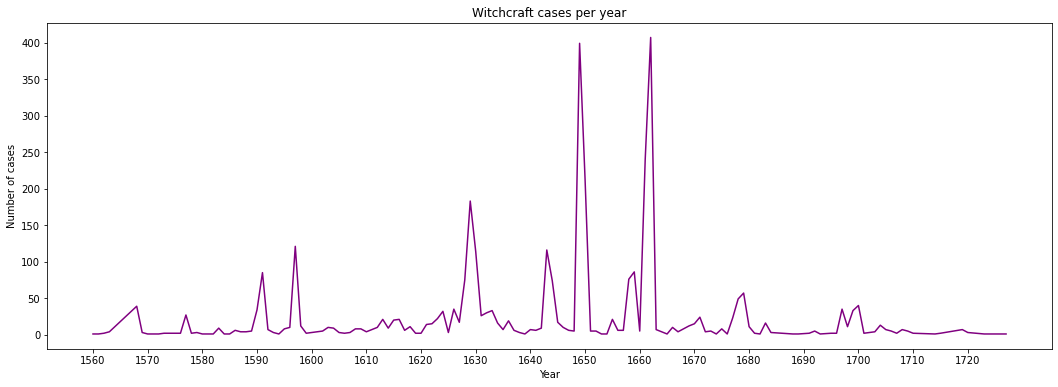

In [145]:
def plot_cases(db):

    count = {}

    mn = 99999999
    mx = 0
    for diz in db:
        d = diz['case_date']
        if '/' in d:
            d = d.split('/')[-1]
        if d not in count:
            count[d] = 1
        else:
            count[d] += 1
        if d != '':
            if int(d) < mn:
                mn = int(d)
            if int(d) > mx:
                mx = int(d)

    del count['']

    my_sorted = sorted([(i, count[i]) for i in count], key = lambda x : x[0])

    ticks = np.arange(mn, mx, 10)

    x = [int(i[0]) for i in my_sorted]
    y = [i[1] for i in my_sorted]


    plt.figure(figsize = (18, 6))
    plt.plot(x, y, color = 'purple')
    plt.title('Witchcraft cases per year')
    plt.xticks(ticks)
    plt.xlabel('Year')
    plt.ylabel('Number of cases')
    plt.show()

plot_cases(cases_db)    

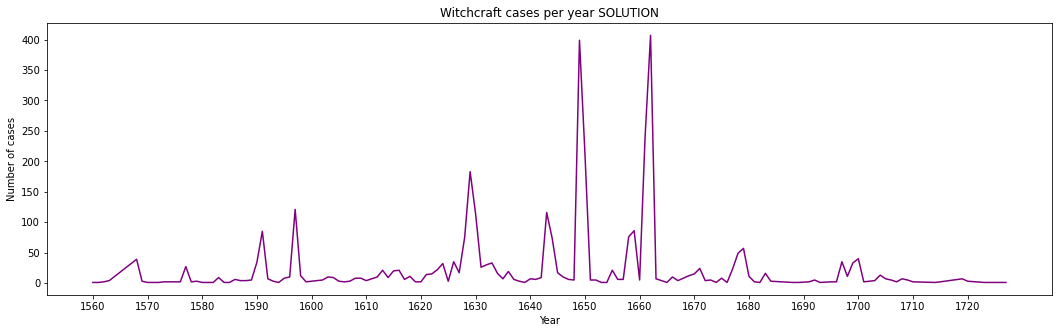

In [10]:
plot_cases(cases_db)

## Part B


## B1.1 Theory - Complexity

**Write the solution in separate `theory.txt` file**

1.  Given a list $L$ of $n$ elements, please compute the asymptotic computational complexity of the following function, explaining your reasoning.

```python

	def my_fun(L):
    		n = len(L)
    		if n <= 1:
        		return 1
    		else:
        		L1 = L[0:n//2]
        		L2 = L[n//2:]
        		a = my_fun(L1) + min(L1)
        		b = my_fun(L2) + min(L2)
        		return max(a, b)
```

## B1.2 Theory - Graph

Briefly describe what a BFS visit of a graph is. Please provide the order of visited nodes of a possible BFS visit on the following graph (starting from node 'a'):

![bfs](img/bfs.jpg)

## B2 Bank

A bank stores all its transactions in a log: possible types of transactions are opening an account, transfering some amount of money, withdrawal, etc. For simplicity, we represent each transaction type with a character, and in the log which is a Python list we put only such characters (we don't care about their meaning).

The bank knows some sequences of events are extremely rare, and probably denote suspicious activity. For simplicitly, we assume such sequences only contain two transactions and represent them in tuples called _biseqs_. 

**NOTE**: a biseq can occur multiple times, but you can consider the number of repetitions negligible with respect to log size.

**THESE EXERCISES ARE ABOUT CUSTOM INDEXING, NOT STRINGS: DO NOT** convert everything to a string, use regexes, nor use string methods like `.index()`, `.replace()`, etc

## B2.1 constructor,  log and pos
 
Implement following methods, adding some appropriate indexing data structure.
 
```python 

class Bank:

    def __init__(self):
        """ Initializes an empty bank
        
            Add a data structure of your choice for indexing the log
        """
        self._trans = []
        raise Exception("TODO IMPLEMENT ME!")
        
    def log(self, transaction):
        """ Appends transaction to the log
        
            - REMEMBER to also update the index
            - MUST EXECUTE IN O(1)
        """
```        
 
```python
    def pos(self, biseq):
        """ RETURN a NEW list with all the indeces where the sequence of 
            two transactions can be found
        
            - MUST execute in O(1)
        """
```

**Testing**: `python3 -m unittest bank_test.LogTest`

**Example**:

In [11]:
from bank_sol import *

bank = Bank()
print(bank)

Bank: 


In [12]:
bank.log('a')

In [13]:
print(bank)

Bank: a


In [14]:
print(bank.pos( ('a','b') ))  # <-- a biseq is a tuple

[]


In [15]:
bank.log('b')

In [16]:
print(bank.pos( ('a','b') ))

[0]


In [17]:
bank.log('a')
bank.log('a')
bank.log('a')
bank.log('a')
bank.log('b')
print(bank)

Bank: a,b,a,a,a,a,b


In [18]:
print(bank.pos(('a','b')))

[0, 5]


In [19]:
print(bank.pos(('a','a')))

[2, 3, 4]


## B2.2 revert

```python
    def revert(self):
        """ Completely eliminates last transaction and RETURN it
        
            - if bank is empty, raises IndexError
            
            - REMEMBER to update any index referring to it
            - *MUST* EXECUTE IN O(1)             
        """
```
**Testing**: `python3 -m unittest RevertTest`

**Example:**

In [20]:
bank = Bank()
bank.log('a')
bank.log('b')
bank.log('c')
bank.log('a')
bank.log('b')
print(bank.pos(('a','b')))

[0, 3]


In [21]:
bank.revert()

'b'

In [22]:
print(bank)

Bank: a,b,c,a


In [23]:
print(bank.pos(('a','b')))

[0]


##  B2.3 max_interval

Typically, there is a biseq which triggers a period of suspicious activity, and there is another biseq which ends it. So given a start and an end biseq, the bank wants a report of all the transactions that happened in between:

```python
    def max_interval(self, bi_start, bi_end):
        """ RETURN a list with all the transactions occurred between 
            the *largest* interval among bi-sequences bi_start and bi_end
        
            - bi_start and bi_end are EXCLUDED 
            - if bi_start / bi_end are not found, or if bi_end is before/includes bi_start, 
              raise LookupError
            
            - DO *NOT* MODIFY the data structure
            - MUST EXECUTE IN O(k) where k is the length of the *largest* interval
              you can return
            - consider number of repetitions a negligible size
        """
```
**Testing**: `python -m unittest bank_test.MaxIntervalTest`

**Example**: 

In [24]:
bank = Bank()
bank.log('c')
bank.log('d')
bank.log('c')
bank.log('a')
bank.log('b') # <--- b 
bank.log('e') #      e
bank.log('f') #      --- f     |
bank.log('a') #          a     |
bank.log('f') #          f     | k
bank.log('c') #          c     |
bank.log('b') #      --- b     |
bank.log('a') # <--- a 
bank.log('f') #      f
bank.log('b')
bank.log('e')
bank.log('l')
bank.max_interval( ('b','e'), ('a','f') )

['f', 'a', 'f', 'c', 'b']

In [25]:
#ignore this
import jupman

import bank_test 
jupman.run(bank_test)

.................
----------------------------------------------------------------------
Ran 17 tests in 0.018s

OK
